# Minimize beamwidth of an array with arbitrary 2-D geometry

A derivative work by Judson Wilson, 5/14/2014.<br>
Adapted (with significant changes) from the CVX example of the same name, by Almir Mutapcic, 2/2/2006.


Topic References:

* "Convex optimization examples" lecture notes (EE364) by S. Boyd
* "Antenna array pattern synthesis via convex optimization" by H. Lebret and S. Boyd

## Introduction

This algorithm designs an antenna array such that:

* it has unit sensitivity at some target direction  
* it obeys a constraint on a minimum sidelobe level outside the beam
* it minimizes the beamwidth of the pattern.

This is a quasiconvex problem. Define the target direction as $\theta_{\mbox{tar}}$, and a beamwidth of $\Delta \theta_{\mbox{bw}}$. The beam occupies the angular interval

$$\Theta_b = \left(\theta_{\mbox{tar}}
-\frac{1}{2}\Delta \theta_{\mbox{bw}},\; \theta_{\mbox{tar}} 
+ \frac{1}{2}\Delta \theta_{\mbox{bw}}\right).
$$

Solving for the minimum beamwidth $\Delta \theta_{\mbox{bw}}$ is performed by bisection, where the interval which contains the optimal value is bisected  according to the result of the following feasibility problem:

\begin{array}{ll}
\mbox{minimize}   &  0 \\
\mbox{subject to} & y(\theta_{\mbox{tar}}) = 1 \\
                  &  \left|y(\theta)\right| \leq t_{\mbox{sb}} 
                         \quad \forall \theta \notin \Theta_b.
\end{array}
    
$y$ is the antenna array gain pattern (a complex-valued function), $t_{\mbox{sb}}$ is the maximum allowed sideband gain threshold, and the variables are $w$ (antenna array weights or shading coefficients). The gain pattern is a linear function of $w$: $y(\theta) = w^T a(\theta)$ for some $a(\theta)$ describing the antenna array configuration and specs.

Once the optimal beamwidth is found, the solution $w$ is refined with the following optimization:

\begin{array}{ll}
\mbox{minimize}   &  \|w\| \\
\mbox{subject to} & y(\theta_{\mbox{tar}}) = 1 \\
                  & \left|y(\theta)\right|  \leq t_{\mbox{sb}}
                          \quad \forall \theta \notin \Theta_b.
\end{array}

The implementation below discretizes the angular quantities and their counterparts, such as $\theta$.

## Problem specification and data

### Antenna array selection

Choose either:

* A random 2D positioning of antennas.
* A uniform 1D positioning of antennas along a line.
* A uniform 2D positioning of antennas along a grid.

In [1]:
import cvxpy as cp
import numpy as np

# Select array geometry:
ARRAY_GEOMETRY = '2D_RANDOM'
#ARRAY_GEOMETRY = '1D_UNIFORM_LINE'
#ARRAY_GEOMETRY = '2D_UNIFORM_LATTICE'

## Data generation

In [2]:
#
# Problem specs.
#
lambda_wl = 1         # wavelength
theta_tar = 60        # target direction
min_sidelobe = -20    # maximum sidelobe level in dB

max_half_beam = 50    # starting half beamwidth (must be feasible)

#
# 2D_RANDOM: 
#     n randomly located elements in 2D.
#
if ARRAY_GEOMETRY == '2D_RANDOM':
    # Set random seed for repeatable experiments.
    np.random.seed(1)
    # Uniformly distributed on [0,L]-by-[0,L] square.
    n = 36
    L = 5
    loc = L*np.random.random((n,2))

#
# 1D_UNIFORM_LINE:
#     Uniform 1D array with n elements with inter-element spacing d.
#
elif ARRAY_GEOMETRY == '1D_UNIFORM_LINE':
    n = 30
    d = 0.45*lambda_wl
    loc = np.hstack(( d * np.array(range(0,n)).reshape(-1, 1), \
                          np.zeros((n,1)) ))

#
# 2D_UNIFORM_LATTICE:
#     Uniform 2D array with m-by-m element with d spacing.
#
elif ARRAY_GEOMETRY == '2D_UNIFORM_LATTICE':
    m = 6
    n = m**2
    d = 0.45*lambda_wl

    loc = np.zeros((n, 2))
    for x in range(m):
        for y in range(m):
            loc[m*y+x,:] = [x,y]
    loc = loc*d

else:
    raise Exception('Undefined array geometry')


#
# Construct optimization data.
#

# Build matrix A that relates w and y(theta), ie, y = A*w.
theta = np.array(range(1, 360+1)).reshape(-1, 1)
A = np.kron(np.cos(np.pi*theta/180), loc[:, 0].T) \
  + np.kron(np.sin(np.pi*theta/180), loc[:, 1].T)
A = np.exp(2*np.pi*1j/lambda_wl*A)

# Target constraint matrix.
ind_closest = np.argmin(np.abs(theta - theta_tar))
Atar = A[ind_closest,:]

## Solve using bisection algorithm

In [3]:
# Bisection range limits. Reduce by half each step.
halfbeam_bot = 1
halfbeam_top = max_half_beam

print('We are only considering integer values of the half beam-width')
print('(since we are sampling the angle with 1 degree resolution).')
print('')

# Iterate bisection until 1 angular degree of uncertainty.
while halfbeam_top - halfbeam_bot > 1:
    # Width in degrees of the current half-beam.
    halfbeam_cur = np.ceil( (halfbeam_top + halfbeam_bot)/2.0 )

    # Create optimization matrices for the stopband,
    # i.e. only A values for the stopband angles.
    ind = np.nonzero(np.squeeze(np.array(np.logical_or( \
               theta <= (theta_tar-halfbeam_cur), \
               theta >= (theta_tar+halfbeam_cur) ))))
    As = A[ind[0],:]
    
    #
    # Formulate and solve the feasibility antenna array problem.
    #

    # As of this writing (2014/05/14) cvxpy does not do complex valued math,
    # so the real and complex values must be stored seperately as reals
    # and operated on as follows:
    #     Let any vector or matrix be represented as a+bj, or A+Bj.
    #     Vectors are stored [a; b] and matrices as [A -B; B A]:
    
    # Atar as [A -B; B A]
    Atar_R = Atar.real
    Atar_I = Atar.imag
    neg_Atar_I = -Atar_I
    Atar_RI = np.block([[Atar_R, neg_Atar_I], [Atar_I, Atar_R]])

    # As as [A -B; B A]
    As_R = As.real
    As_I = As.imag
    neg_As_I = -As_I
    As_RI = np.block([[As_R, neg_As_I], [As_I, As_R]])
    As_RI_top = np.block([As_R, neg_As_I])
    As_RI_bot = np.block([As_I, As_R])

    # 1-vector as [1, 0] since no imaginary part
    realones_ri = np.array([1.0, 0.0])

    # Create cvxpy variables and constraints
    w_ri = cp.Variable(shape=(2*n))
    constraints = [ Atar_RI*w_ri == realones_ri]
    # Must add complex valued constraint 
    # abs(As*w <= 10**(min_sidelobe/20)) row by row by hand.
    # TODO: Future version use norms() or complex math
    # when these features become available in cvxpy.
    for i in range(As.shape[0]):
        #Make a matrix whos product with w_ri is a 2-vector
        #which is the real and imag component of a row of As*w
        As_ri_row = np.vstack((As_RI_top[i, :], As_RI_bot[i, :]))
        constraints.append( \
                cp.norm(As_ri_row*w_ri) <= 10**(min_sidelobe/20) )

    # Form and solve problem.
    obj = cp.Minimize(0)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.CVXOPT)

    # Bisection (or fail).
    if prob.status == cp.OPTIMAL:
        print('Problem is feasible for half beam-width = {}'
              ' degress'.format(halfbeam_cur))
        halfbeam_top = halfbeam_cur
    elif prob.status == cp.INFEASIBLE:
        print('Problem is not feasible for half beam-width = {}'
              ' degress'.format(halfbeam_cur))
        halfbeam_bot = halfbeam_cur
    else:
        raise Exception('CVXPY Error')

# Optimal beamwidth.
halfbeam = halfbeam_top
print('Optimum half beam-width for given specs is {}'.format(halfbeam))

# Compute the minimum noise design for the optimal beamwidth
ind = np.nonzero(np.squeeze(np.array(np.logical_or( \
                theta <= (theta_tar-halfbeam), \
                theta >= (theta_tar+halfbeam) ))))
As = A[ind[0],:]

# As as [A -B; B A]
# See earlier calculations for real/imaginary representation
As_R = As.real
As_I = As.imag
neg_As_I = -As_I
As_RI = np.block([[As_R, neg_As_I], [As_I, As_R]])
As_RI_top = np.block([As_R, neg_As_I])
As_RI_bot = np.block([As_I, As_R])

constraints = [ Atar_RI*w_ri == realones_ri]
# Same constraint as a above, on new As (hense different
# actual number of constraints). See comments above.
for i in range(As.shape[0]):
    As_ri_row = np.vstack((As_RI_top[i, :], As_RI_bot[i, :]))
    constraints.append( \
        cp.norm(As_ri_row*w_ri) <= 10**(min_sidelobe/20) )

# Form and solve problem.
# Note the new objective!
obj = cp.Minimize(cp.norm(w_ri))
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.SCS)

#if prob.status != cp.OPTIMAL:
#    raise Exception('CVXPY Error')
print("final objective value: {}".format(obj.value))

We are only considering integer values of the half beam-width
(since we are sampling the angle with 1 degree resolution).

Problem is feasible for half beam-width = 26.0 degress
Problem is feasible for half beam-width = 14.0 degress
Problem is not feasible for half beam-width = 8.0 degress
Problem is feasible for half beam-width = 11.0 degress
Problem is feasible for half beam-width = 10.0 degress
Problem is feasible for half beam-width = 9.0 degress
Optimum half beam-width for given specs is 9.0
final objective value: 1.6616084212553195


## Result plots

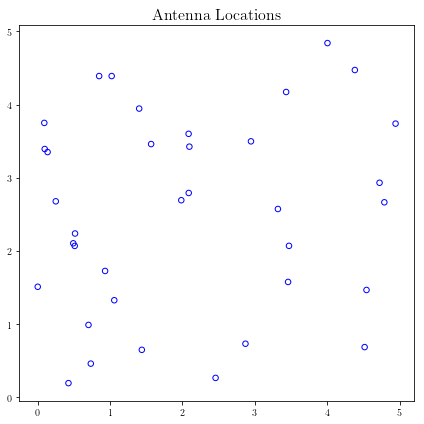

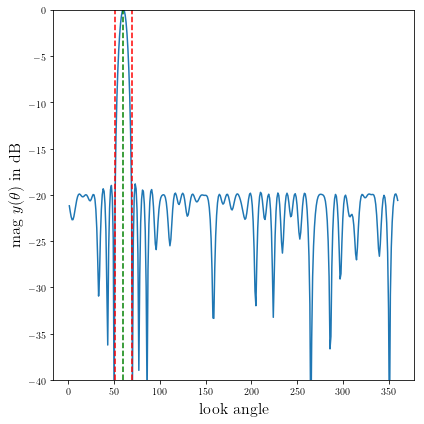

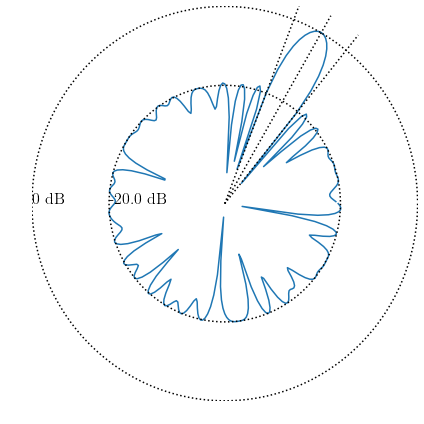

In [4]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#
# First Figure: Antenna Locations
#
plt.figure(figsize=(6, 6))
plt.scatter(loc[:, 0], loc[:, 1],
            s=30, facecolors='none', edgecolors='b')
plt.title('Antenna Locations', fontsize=16)
plt.tight_layout()
plt.show()

#
# Second Plot: Array Pattern
#

# Complex valued math to calculate y = A*w_im;
# See comments in code above regarding complex representation as reals.
A_R = A.real
A_I = A.imag
neg_A_I = -A_I
A_RI = np.block([[A_R, neg_A_I], [A_I, A_R]]);

y = A_RI.dot(w_ri.value)
y = y[0:int(y.shape[0]/2)] + 1j*y[int(y.shape[0]/2):] #now native complex

plt.figure(figsize=(6,6))
ymin, ymax = -40, 0
plt.plot(np.arange(360)+1, np.array(20*np.log10(np.abs(y))))
plt.plot([theta_tar, theta_tar], [ymin, ymax], 'g--')
plt.plot([theta_tar+halfbeam, theta_tar+halfbeam], [ymin, ymax], 'r--')
plt.plot([theta_tar-halfbeam, theta_tar-halfbeam], [ymin, ymax], 'r--')
plt.xlabel('look angle', fontsize=16)
plt.ylabel(r'mag $y(\theta)$ in dB', fontsize=16)
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#
# Third Plot: Polar Pattern
#
plt.figure(figsize=(6,6))
zerodB = 50
dBY = 20*np.log10(np.abs(y)) + zerodB
plt.plot(dBY * np.cos(np.pi*theta.flatten()/180),
         dBY * np.sin(np.pi*theta.flatten()/180))
plt.xlim(-zerodB, zerodB)
plt.ylim(-zerodB, zerodB)
plt.axis('off')

# 0 dB level.
plt.plot(zerodB*np.cos(np.pi*theta.flatten()/180),
         zerodB*np.sin(np.pi*theta.flatten()/180), 'k:')
plt.text(-zerodB,0,'0 dB', fontsize=16)
# Max sideband level.
m=min_sidelobe + zerodB
plt.plot(m*np.cos(np.pi*theta.flatten()/180),
         m*np.sin(np.pi*theta.flatten()/180), 'k:')
plt.text(-m,0,'{:.1f} dB'.format(min_sidelobe), fontsize=16)
#Lobe center and boundaries angles.
theta_1 = theta_tar+halfbeam
theta_2 = theta_tar-halfbeam
plt.plot([0, 55*np.cos(theta_tar*np.pi/180)], \
         [0, 55*np.sin(theta_tar*np.pi/180)], 'k:')
plt.plot([0, 55*np.cos(theta_1*np.pi/180)], \
         [0, 55*np.sin(theta_1*np.pi/180)], 'k:')
plt.plot([0, 55*np.cos(theta_2*np.pi/180)], \
         [0, 55*np.sin(theta_2*np.pi/180)], 'k:')

#Show plot.
plt.tight_layout()
plt.show()